In [1]:
import os
os.environ["DDE_BACKEND"] = "pytorch"
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


The system of ODEs,

$$\frac{dx}{dt} + 2x + y = 0$$
$$\frac{dy}{dt} + y + 2x = 0$$
where,
$$t \in [0, 5]$$
The initial conditions are,

$$x(0) = 1, \;\;\; y(0) = 0$$

The exact solutions are,

$$x(t) = \frac{1}{2}(e^{-t} + e^{-3t})$$
$$y(t) = \frac{1}{2}(e^{-3t} - e^{-t})$$

In [2]:
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [3]:
t = np.linspace(0, 5, 500)
x_analytical = 0.5*np.exp(-t) + 0.5*np.exp(-3*t)
y_analytical = -0.5*np.exp(-t) + 0.5*np.exp(-3*t)

In [4]:
def ode_system(x, y):
    dx_dt = dde.grad.jacobian(y, x, i=0)
    dy_dt = dde.grad.jacobian(y, x, i=1)

    eq1 = dx_dt + 2*y[:, 0:1] + y[:, 1:2]
    eq2 = dy_dt + y[:, 0:1] + 2*y[:, 1:2]

    return [eq1, eq2]

In [5]:
def is_on_initial(x, on_initial):
    return on_initial and dde.utils.isclose(x[0], 0)

def initial_value_x(x):
    return 1

def initial_value_y(x):
    return 0

In [6]:
def analytical_x(t):
    return 0.5*np.exp(-t) + 0.5*np.exp(-3*t)

def analytical_y(t):
    return -0.5*np.exp(-t) + 0.5*np.exp(-3*t)

def analytical_solution(t):
    anal_x = analytical_x(t)
    anal_y = analytical_y(t)
    return np.hstack((anal_x, anal_y))

In [7]:
domain = dde.geometry.TimeDomain(0, 5)
icx = dde.icbc.IC(domain, initial_value_x, is_on_initial, component=0)
icy = dde.icbc.IC(domain, initial_value_y, is_on_initial, component=1)

In [8]:
data = dde.data.PDE(domain, ode_system, [icx, icy], num_domain=400, num_boundary=2, solution=analytical_solution, num_test=100)

In [9]:
layer_size = [1] + [50]*3 + [2]
net = dde.nn.FNN(layer_size, "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=3000)

Compiling model...
'compile' took 3.532630 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [5.36e+00, 6.98e+00, 1.00e+00, 0.00e+00]    [5.39e+00, 7.03e+00, 1.00e+00, 0.00e+00]    [4.04e+00]    
1000      [3.84e-04, 8.21e-05, 2.84e-06, 2.49e-06]    [2.02e-04, 2.10e-05, 2.84e-06, 2.49e-06]    [9.12e-03]    
2000      [1.12e-04, 2.36e-05, 1.92e-07, 1.71e-07]    [7.60e-05, 1.46e-05, 1.92e-07, 1.71e-07]    [6.04e-03]    
3000      [4.17e-05, 1.06e-05, 4.10e-08, 3.86e-08]    [2.78e-05, 6.65e-06, 4.10e-08, 3.86e-08]    [3.33e-03]    

Best model at step 3000:
  train loss: 5.23e-05
  test loss: 3.45e-05
  test metric: [3.33e-03]

'train' took 7.712835 s



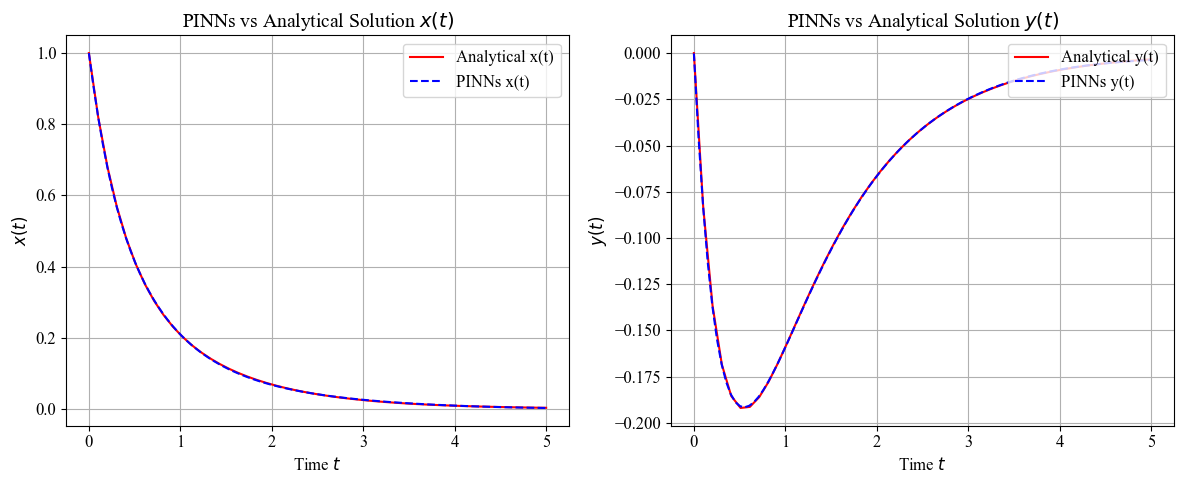

In [11]:
# Predict the solution
t_values_pinn = np.linspace(0, 5, 100)[:, None]
t_values_exact = np.linspace(0, 5, 50)[:, None]

y_pred = model.predict(t_values_pinn)

# Analytical solutions
y_true_x = analytical_x(t_values_exact)
y_true_y = analytical_y(t_values_exact)

# Set up the plot with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t_values_exact, y_true_x, label='Analytical x(t)', color='red')
plt.plot(t_values_pinn, y_pred[:, 0], '--', label="PINNs x(t)", color='blue')
plt.title(r"PINNs vs Analytical Solution $x(t)$", fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

# Plot y(t)
plt.subplot(1, 2, 2)
plt.plot(t_values_exact, y_true_y, label='Analytical y(t)', color='red')
plt.plot(t_values_pinn, y_pred[:, 1], '--', label="PINNs y(t)", color='blue')
plt.title(r"PINNs vs Analytical Solution $y(t)$", fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()